---
---
Modelo Preditivo Petróleo Brent
=======
## FIAP PosTech - Tech Challenge - Fase 4
## **Marcello Vartuli RM352151**


---
---
## Resumo das conclusões do desafio

> #### Foram utilizados 3 métodos distintos para elaboração de um modelo preditivo para Petróleo Brent, tomando como base um intervalo de tempo disponível, iniciando em 20/05/1987.
>
> **LSTM** - Apresentou o melhor resultado pelos indicadores MAPE = 1.15% e Mean Square Error: 8.629660442238674e-05 com a série temporal suavizada.
> 
> **Prophet** - Apresentou o segundo melhor resultado com MAPE = 15.41%
> 
> **ARIMA** - Não provou ser um método adequado, tendo MAPE = 348.66%
>


---
---
## Análise Exploratória dos Dados
---

In [2]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Biblioteca para exportar o modelo treinado
import joblib

# Bibliotecas para scrapping do site IPEA
import requests
from bs4 import BeautifulSoup
from datetime import datetime

#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima
import statsmodels.api as sm

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.metrics import MeanSquaredError
import tensorflow

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

In [3]:
## Função para atualizar os dados já salvos com dados novos
def update_dataframe(df, df_novo):

    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    df_novo['Data'] = pd.to_datetime(df_novo['Data'], dayfirst=True)

    last_date = df['Data'].max()
    new_rows = df_novo[df_novo['Data'] > last_date]

    # Concatena os novos dados com o DataFrame existente se houver novas linhas
    if not new_rows.empty:
        updated_df = pd.concat([df, new_rows], ignore_index=True)
    else:
        updated_df = df

    return updated_df

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisição GET ao site e captura a resposta
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'grd_DXMainTable'})
    new_df = pd.read_html(str(table), header=0)[0]
    new_df.rename(columns={"Preço - petróleo bruto - Brent (FOB)": "Fechamento"}, inplace=True)
    new_df['Fechamento'] = new_df['Fechamento']/100
    path = 'ipea.csv'
    try:
        existing_df = pd.read_csv(path)
    except FileNotFoundError:
        existing_df = new_df  # Se o arquivo não existir, considere os dados atuais como o DataFrame existente

    # Atualiza o DataFrame existente com novos dados (carga incremental)
    updated_df = update_dataframe(existing_df, new_df)

    # Salva o DataFrame atualizado para o arquivo
    updated_df.to_csv(path, index=False)

    # Mostra as primeiras linhas do DataFrame atualizado
    updated_df.set_index('Data')
    print(updated_df.head())
else:
    print('Falha ao acessar a página: Status Code', response.status_code)


        Data  Fechamento
0 2024-05-13       83.18
1 2024-05-10       83.39
2 2024-05-09       83.27
3 2024-05-08       82.44
4 2024-05-07       82.69


In [4]:
df_eda = updated_df.set_index('Data').sort_index(ascending=True)

In [5]:
df_eda.head(10)

,Fechamento
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
1987-05-27,18.60
1987-05-28,18.60
1987-05-29,18.58
1987-06-01,18.65


---
### Entendendo o comportamento dos dados e os fatores preponderantes para a escolha de um modelo preditivo

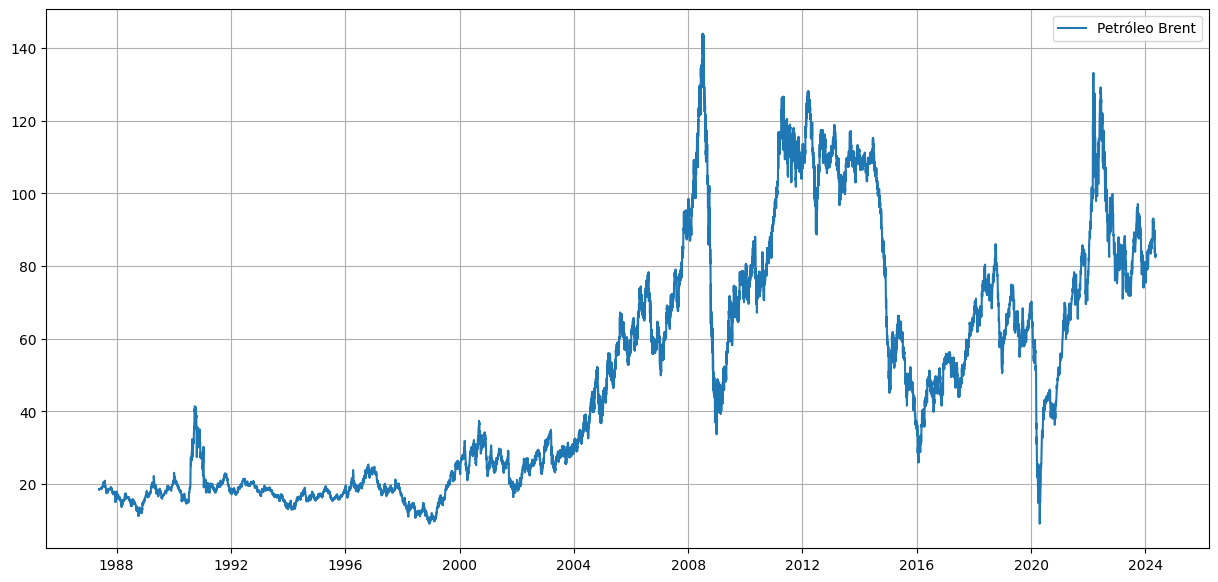

In [6]:
plt.figure(figsize = (15,7))
plt.plot(df_eda.index, df_eda['Fechamento'], label='Petróleo Brent')
plt.grid(True)
plt.legend(loc='best')

#### Aqui é feita a decomposição da Série Temporal para identificar a tendência, sazonalidade e ruído

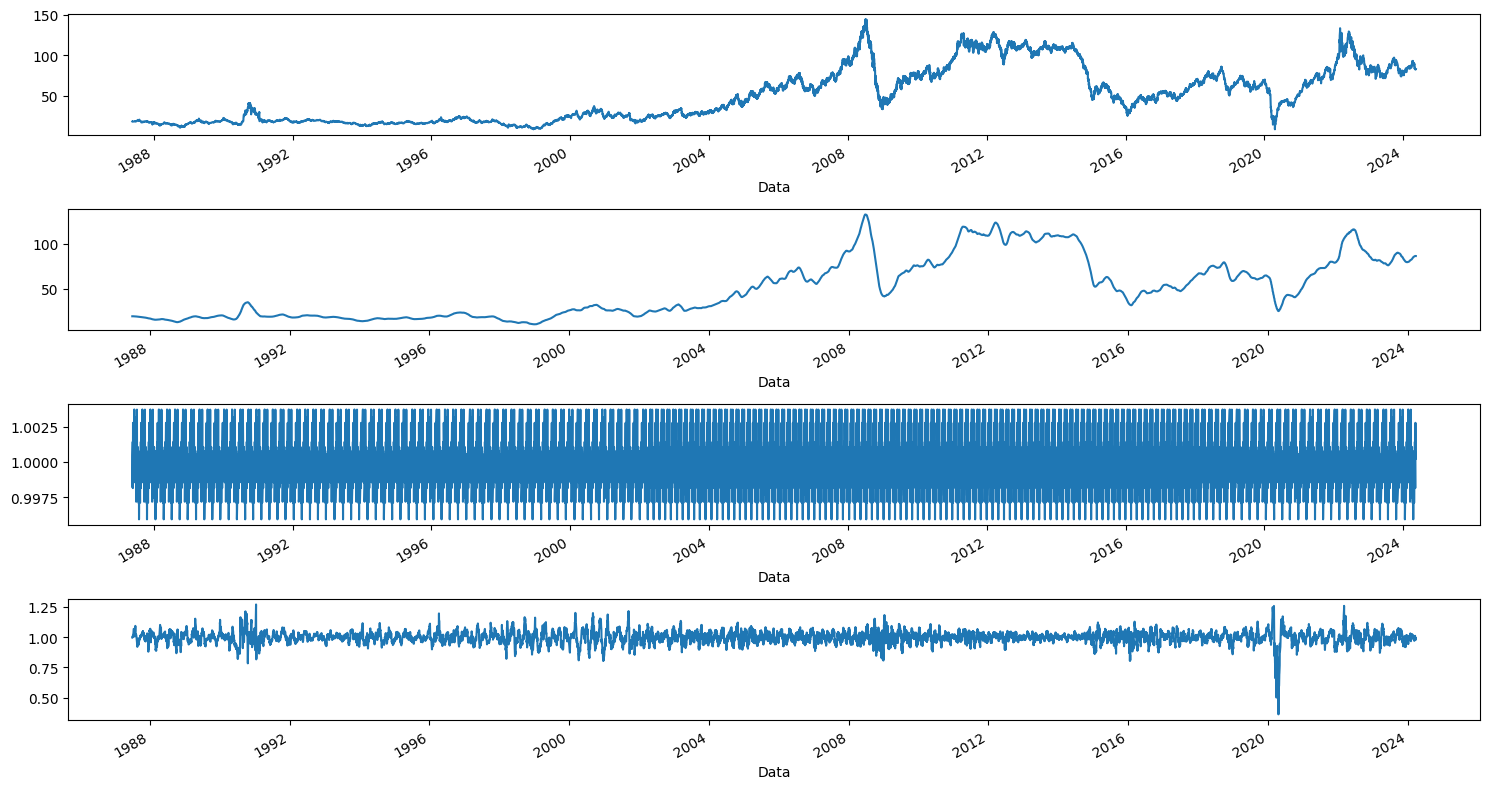

In [7]:
seasonplt_decomposed = seasonal_decompose(df_eda, model='multiplicative', period=60) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplt_decomposed.observed.plot(ax=ax1) #serie real
seasonplt_decomposed.trend.plot(ax=ax2)    #tendencia
seasonplt_decomposed.seasonal.plot(ax=ax3) #sazonalisade
seasonplt_decomposed.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

---
---
## Modelos Preditivos


---
### Testando o modelo com LSTM
---

In [8]:
df_lstm = df_eda.reset_index('Data')

df_lstm.head()

,Data,Fechamento
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [9]:
fechamento = df_lstm['Fechamento'].values
fechamento = fechamento.reshape(-1,1) #transformar em array

#### Normalização dos dados

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(fechamento)
fechamento = scaler.transform(fechamento)

#### Separando base de treino e base de teste

In [11]:
df_lstm.head()

,Data,Fechamento
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [12]:
split_percent = 0.80
split = int(split_percent*len(fechamento))

fechamento_train = fechamento[:split]
fechamento_test = fechamento[split:]

data_train = df_lstm['Data'][:split]
data_test = df_lstm['Data'][split:]

print(len(fechamento_train))
print(len(fechamento_test))

8935
2234


In [13]:
data_train.head()

0   1987-05-20
1   1987-05-21
2   1987-05-22
3   1987-05-25
4   1987-05-26
Name: Data, dtype: datetime64[ns]

In [14]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(fechamento_train, fechamento_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(fechamento_test, fechamento_test, length=look_back, batch_size=1)

In [15]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
447/447 [==============================] - 6s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 2/20
447/447 [==============================] - 4s 8ms/step - loss: 5.9779e-04 - mean_squared_error: 5.9779e-04
Epoch 3/20
447/447 [==============================] - 4s 8ms/step - loss: 4.9557e-04 - mean_squared_error: 4.9557e-04
Epoch 4/20
447/447 [==============================] - 4s 9ms/step - loss: 9.4455e-04 - mean_squared_error: 9.4455e-04
Epoch 5/20
447/447 [==============================] - 4s 8ms/step - loss: 2.1571e-04 - mean_squared_error: 2.1571e-04
Epoch 6/20
447/447 [==============================] - 4s 8ms/step - loss: 2.3991e-04 - mean_squared_error: 2.3991e-04
Epoch 7/20
447/447 [==============================] - 4s 8ms/step - loss: 2.5692e-04 - mean_squared_error: 2.5692e-04
Epoch 8/20
447/447 [==============================] - 4s 8ms/step - loss: 2.6764e-04 - mean_squared_error: 2.6764e-04
Epoch 9/20
447/447 [==============================] - 4s 8ms/ste

In [16]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

2224/2224 [==============================] - 5s 2ms/step - loss: 2.4324e-04 - mean_squared_error: 2.4324e-04
Erro Quadrático Médio 0.00024323948309756815


In [17]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(fechamento_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

2224/2224 [==============================] - 5s 2ms/step
MAPE: 4.8234


In [18]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.01559613680042491


In [19]:
prediction = model.predict(test_generator)

fechamento_train = fechamento_train.reshape((-1))
fechamento_test = fechamento_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = data_train,
    y = fechamento_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = data_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = data_test,
    y = fechamento_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições Petróleo Brent",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

2224/2224 [==============================] - 5s 2ms/step


### Validação com a série temporal suavizada

In [20]:
df_lstms = df_eda.reset_index('Data')

df_lstms.head()

,Data,Fechamento
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


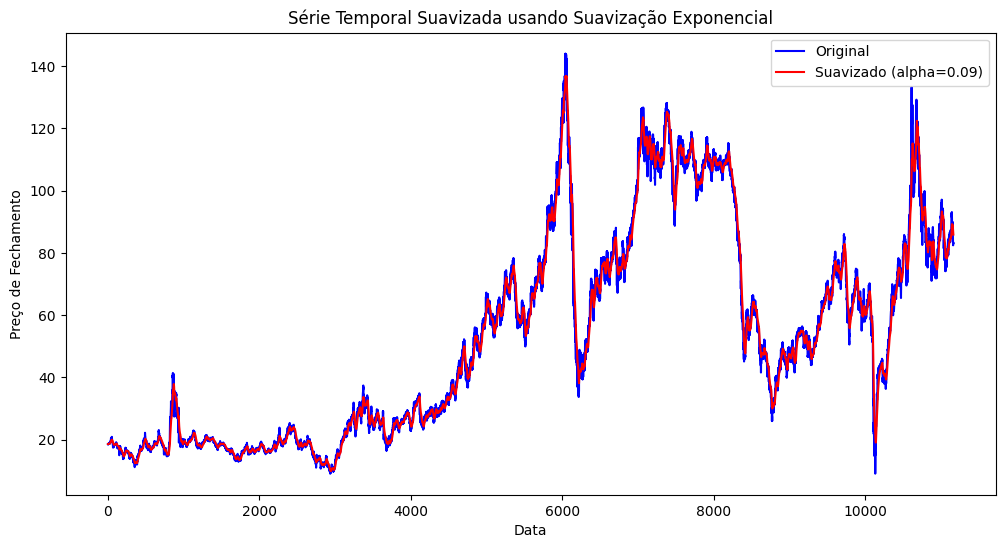

In [21]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df_lstms['Smoothed_Close'] = df_lstms['Fechamento'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_lstms.index, df_lstms['Fechamento'], label='Original', color='blue')
plt.plot(df_lstms.index, df_lstms['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [22]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_lstms['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.080708779994787
p-value: 0.2523421110160904
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.080708779994787
Valor-p: 0.2523421110160904
Valores Críticos:
   1%: -3.4309373570405923
   5%: -2.8617995797890816
   10%: -2.5669081692030327


In [23]:
df_lstms.drop(columns=['Fechamento'], inplace=True)
df_lstms.head()

,Data,Smoothed_Close
0,1987-05-20,18.630000
1,1987-05-21,18.613800
2,1987-05-22,18.608058
3,1987-05-25,18.607333
4,1987-05-26,18.609373


In [24]:
fechamento_s = df_lstms['Smoothed_Close'].values
fechamento_s = fechamento_s.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(fechamento_s)
fechamento_s = scaler.transform(fechamento_s)
fechamento_s

array([[0.06820521],
       [0.06807747],
       [0.06803219],
       ...,
       [0.6028669 ],
       [0.60070812],
       [0.5985946 ]])

In [25]:
split_percent = 0.80
split = int(split_percent*len(fechamento_s))

fechamento_s_train = fechamento_s[:split]
fechamento_s_test = fechamento_s[split:]

data_s_train = df_lstms['Data'][:split]
data_s_test = df_lstms['Data'][split:]

print(len(fechamento_s_train))
print(len(fechamento_s_test))

8935
2234


In [26]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(fechamento_s_train, fechamento_s_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(fechamento_s_test, fechamento_s_test, length=look_back, batch_size=1)

In [27]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
447/447 [==============================] - 5s 5ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 2/20
447/447 [==============================] - 2s 5ms/step - loss: 6.0031e-05 - mean_squared_error: 6.0031e-05
Epoch 3/20
447/447 [==============================] - 3s 6ms/step - loss: 1.1834e-04 - mean_squared_error: 1.1834e-04
Epoch 4/20
447/447 [==============================] - 3s 6ms/step - loss: 1.1204e-04 - mean_squared_error: 1.1204e-04
Epoch 5/20
447/447 [==============================] - 2s 5ms/step - loss: 1.4744e-04 - mean_squared_error: 1.4744e-04
Epoch 6/20
447/447 [==============================] - 3s 6ms/step - loss: 1.4890e-04 - mean_squared_error: 1.4890e-04
Epoch 7/20
447/447 [==============================] - 2s 5ms/step - loss: 9.6538e-05 - mean_squared_error: 9.6538e-05
Epoch 8/20
447/447 [==============================] - 2s 5ms/step - loss: 1.6616e-04 - mean_squared_error: 1.6616e-04
Epoch 9/20
447/447 [==============================] - 2s 5ms/ste

In [28]:
# Salva o modelo treinado em arquivo
model.save('modelobrent')

INFO:tensorflow:Assets written to: modelobrent\assets


INFO:tensorflow:Assets written to: modelobrent\assets


In [29]:
neural_model = model = tensorflow.keras.models.load_model('modelobrent')


In [30]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = neural_model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(fechamento_s_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")

2229/2229 [==============================] - 4s 2ms/step
MAPE: 1.15%


In [31]:
# Avaliando o modelo nos dados de teste
mse = neural_model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

2229/2229 [==============================] - 4s 2ms/step - loss: 8.6297e-05 - mean_squared_error: 8.6297e-05
Erro Quadrático Médio: 8.629660442238674e-05


In [32]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.009289596569409607


In [33]:
prediction = neural_model.predict(test_generator)

fechamento_s_train = fechamento_s_train.reshape((-1))
fechamento_s_test = fechamento_s_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = data_s_train,
    y = fechamento_s_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = data_s_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = data_s_test,
    y = fechamento_s_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da Petróleo Brent",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

2229/2229 [==============================] - 4s 2ms/step


Realizando o Forecasting

In [34]:
fechamento_s = fechamento_s.reshape((-1))


# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = fechamento_s[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df_lstms['Data'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, neural_model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 26ms/step


In [35]:
trace1 = go.Scatter(
    x = data_s_test,
    y = fechamento_s_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast Petróleo Brent",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

Organizando em um dataframe

In [36]:
df_past = pd.DataFrame(df_lstms)
df_past = df_past[['Data','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Data'] = pd.to_datetime(df_past['Data'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

,Data,Actual,Forecast
0,1987-05-20,18.630000,NaN
1,1987-05-21,18.613800,NaN
2,1987-05-22,18.608058,NaN


In [37]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [38]:
forecast

array([[85.88999715],
       [85.44080521],
       [85.10384979],
       [84.77532222],
       [84.45081583],
       [84.12222024],
       [83.78563519],
       [83.46502149],
       [83.14780161],
       [82.83396798],
       [82.52287813],
       [82.21533328],
       [81.91070604],
       [81.60855048],
       [81.30944859],
       [81.01333235]])

In [39]:
df_future = pd.DataFrame(columns=['Data', 'Actual', 'Forecast'])
df_future['Data'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Data,Actual,Forecast
0,2024-05-13,NaN,85.889997
1,2024-05-14,NaN,85.440805
2,2024-05-15,NaN,85.103850
3,2024-05-16,NaN,84.775322
4,2024-05-17,NaN,84.450816


In [40]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Data')
results.head()

,Actual,Forecast
Data,,
1987-05-20,18.630000,NaN
1987-05-21,18.613800,NaN
1987-05-22,18.608058,NaN
1987-05-25,18.607333,NaN
1987-05-26,18.609373,NaN


In [41]:
results.tail()

,Actual,Forecast
Data,,
2024-05-24,NaN,82.215333
2024-05-25,NaN,81.910706
2024-05-26,NaN,81.608550
2024-05-27,NaN,81.309449
2024-05-28,NaN,81.013332


In [42]:
results.loc['2023-01-01':]

,Actual,Forecast
Data,,
2023-01-02,82.282236,NaN
2023-01-03,82.109235,NaN
2023-01-04,81.497304,NaN
2023-01-05,81.068247,NaN
2023-01-06,80.649004,NaN
...,...,...
2024-05-24,NaN,82.215333
2024-05-25,NaN,81.910706
2024-05-26,NaN,81.608550


In [43]:
results2023 =  results.loc['2023-01-01':]

In [44]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast Petróleo Brent'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'

---
### Testando o modelo com Prophet
---

In [45]:
df_eda

,Fechamento
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2024-05-07,82.69
2024-05-08,82.44
2024-05-09,83.27


In [46]:
df_prophet = df_eda.reset_index('Data')

df_prophet.head()

,Data,Fechamento
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [47]:
df_prophet[['ds','y']] = df_prophet[['Data','Fechamento']]

In [48]:
train_data = df_prophet.sample(frac=0.8, random_state=0)
test_data = df_prophet.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (8935, 4)
testing data size : (2234, 4)


In [49]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (c:\projetos\PosTech_TC_Fase4\venv\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
DEBUG:cmdstanpy:input tempfile: C:\Users\baceio\AppData\Local\Temp\tmpyq17hzus\rll_jugb.json
DEBUG:cmdstanpy:input tempfile: C:\Users\baceio\AppData\Local\Temp\tmpyq17hzus\x57jqye7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\projetos\\PosTech_TC_Fase4\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=7449', 'data', 'file=C:\\Users\\baceio\\AppData\\Local\\Temp\\tmpyq17hzus\\rll_jugb.json', 'init=C:\\Users\\baceio\\AppData\\Local\\Temp\\tmpyq17hzus\\x57jqye7.json', 'output', 'file=C:\\Users\\baceio\\AppData\\Local\\Temp\\tmpyq17hzus\\prophet_modelhiqqdz5u\\prophet_model-20240518203910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:39:10 - cmdstanpy - INFO - Chain [1] start pr

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-21,17.576583,3.434759,32.123268,17.576583,17.576583,0.218966,0.218966,0.218966,-1.023266,...,0.093623,0.093623,0.093623,1.148608,1.148608,1.148608,0.0,0.0,0.0,17.795548
1,1987-05-22,17.579467,3.489065,30.367409,17.579467,17.579467,-0.016901,-0.016901,-0.016901,-1.023266,...,-0.151697,-0.151697,-0.151697,1.158062,1.158062,1.158062,0.0,0.0,0.0,17.562566
2,1987-05-25,17.588120,4.669943,31.175675,17.588120,17.588120,0.219799,0.219799,0.219799,-1.023266,...,0.060974,0.060974,0.060974,1.182091,1.182091,1.182091,0.0,0.0,0.0,17.807919
3,1987-05-26,17.591004,3.790766,31.728023,17.591004,17.591004,0.062048,0.062048,0.062048,-1.023266,...,-0.103820,-0.103820,-0.103820,1.189134,1.189134,1.189134,0.0,0.0,0.0,17.653053
4,1987-05-27,17.593889,4.509901,32.056823,17.593889,17.593889,0.178072,0.178072,0.178072,-1.023266,...,0.005337,0.005337,0.005337,1.196001,1.196001,1.196001,0.0,0.0,0.0,17.771960


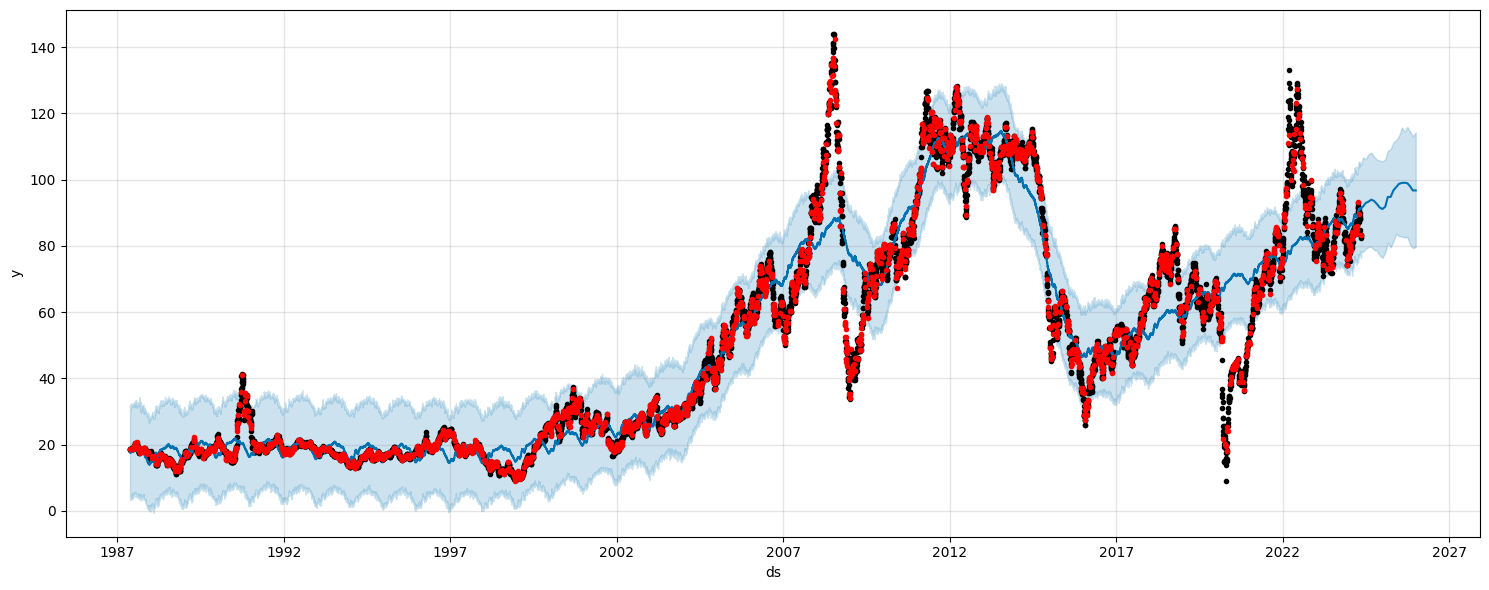

In [50]:
modelo.plot(previsao, figsize=(15,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

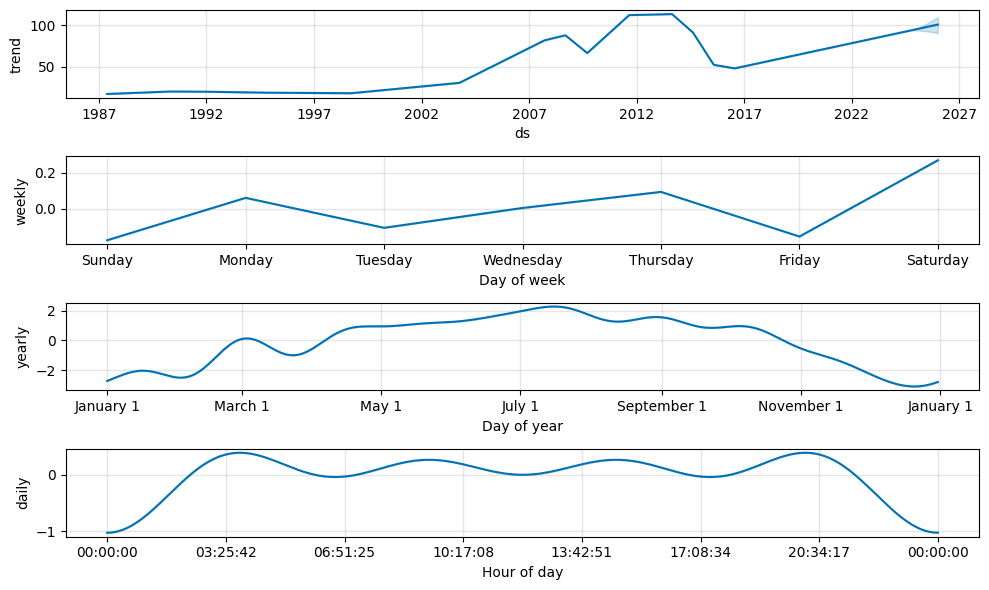

In [51]:
modelo.plot_components(previsao, figsize=(10,6));

In [52]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 15.41%


---
### Testando o modelo ARIMA
---

#### Analisando a correlação dos dados

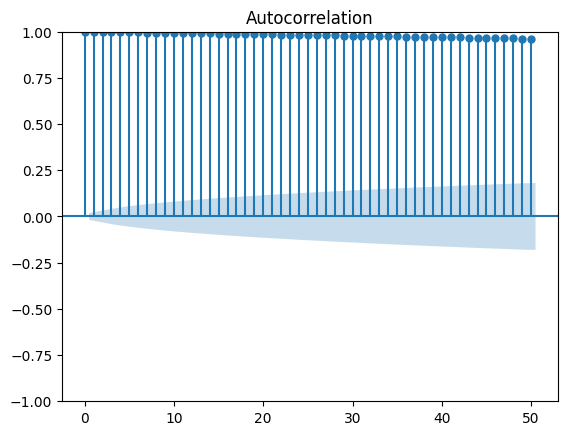

In [53]:
df_arima = df_eda
sm.graphics.tsa.plot_acf(df_arima, lags=50)
plt.show()

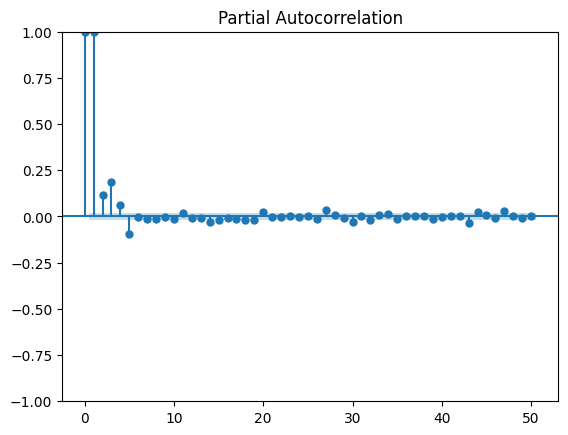

In [54]:
sm.graphics.tsa.plot_pacf(df_arima, lags=50)
plt.show()

> Percebemos no gráfico de Autocorrelação que todos os pontos no intervalo de 50 dias se encontram fora do intervalo de confiança de 95% demonstrando elevado grau de autocorrelação.
> 
> No gráfico de Autocorrelação Parcial Direta vemos que não há correlação significativa dos lags, por estarem dentro do intervalo de confiança de 95%.

#### Verificando a estacionariedade da série temporal

Outro pontro importante para se identificar é a estacionariedade da série temporal, definindo os próximos passos para a aplicação do modelo preditivo.

Pela decomposição vista acima podemos visualmente verificar o comportamento não estacionário, porém abaixo iremos utilizar um modelo estatísco para comprovar a hipótese.

Será utilizado o teste de Dickey-Fuller Aumentado (ADF), com um Valor p (p-value) de 0.05 de significância contra a hipótese nula (Serie Temporal não estacionária).

**Função para teste da estacionariedade da série temporal**


In [55]:
def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Fechamento'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

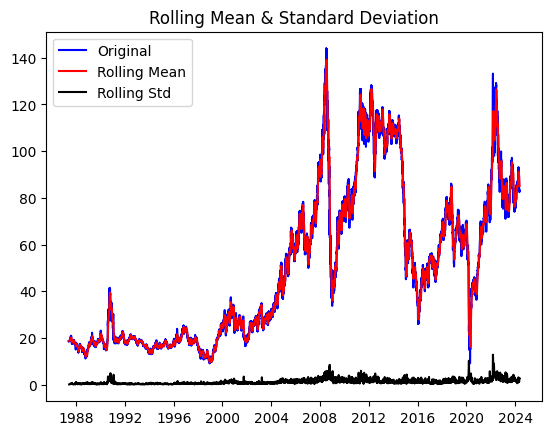

Results of Dickey Fuller Test:
Test Statistic                    -2.076576
p-value                            0.254037
#Lags Used                        31.000000
Number of Observations Used    11137.000000
Critical Value (1%)               -3.430937
Critical Value (5%)               -2.861800
Critical Value (10%)              -2.566908
dtype: float64


In [56]:
test_stationarity(df_arima)

> Podemos ver que o Valor-p está **muito acima** do limite estabelecido de 0.05, bem como os valores críticos de confiança estão bem **distanciados do teste estatístico.**
> 
> Com estes resultados podemos concluir que **a série temporal não é estacionária**

#### Transformando a Série em Estacionária

**Teste 1 - Subtrair os dados transformados pelo log da média móvel**

Neste método procuramos estabilizar as variações da série temporal, removendo o componenete de tendência.

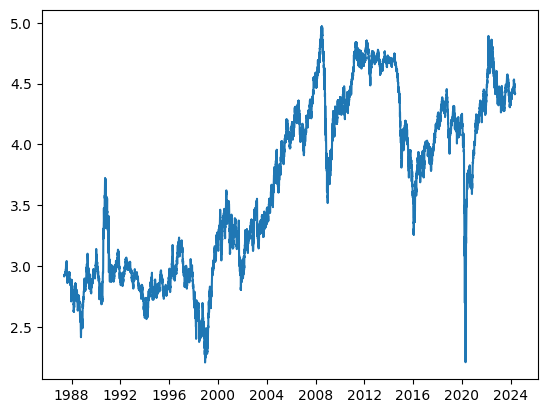

In [57]:
indexedDataset_logScale = np.log(df_arima)
plt.plot(indexedDataset_logScale)

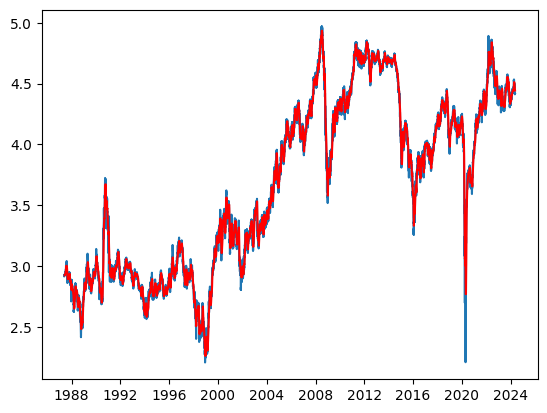

In [58]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [59]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

,Fechamento
Data,
1987-05-20,NaN
1987-05-21,NaN
1987-05-22,NaN
1987-05-25,NaN
1987-05-26,NaN
1987-05-27,NaN
1987-05-28,NaN
1987-05-29,NaN
1987-06-01,NaN


In [60]:
#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Fechamento
Data,
1987-06-04,0.008298
1987-06-05,0.001262
1987-06-08,0.005265
1987-06-09,0.005837
1987-06-10,0.005035
1987-06-11,-0.000528
1987-06-12,0.004009
1987-06-16,0.009045
1987-06-17,0.013905


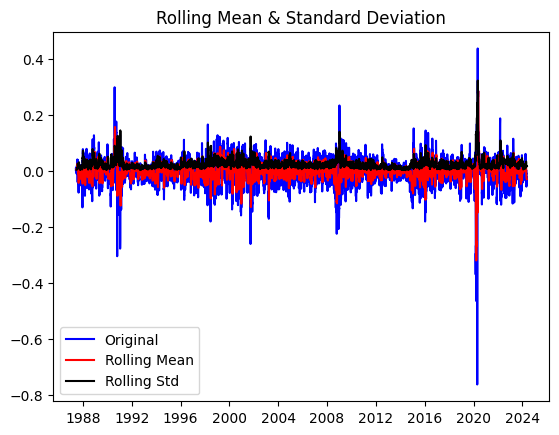

Results of Dickey Fuller Test:
Test Statistic                -1.765398e+01
p-value                        3.708813e-30
#Lags Used                     2.600000e+01
Number of Observations Used    1.113100e+04
Critical Value (1%)           -3.430938e+00
Critical Value (5%)           -2.861800e+00
Critical Value (10%)          -2.566908e+00
dtype: float64


In [61]:
test_stationarity(datasetLogScaleMinusMovingAverage)

**Teste 2 - Decaimento Exponencial**

Neste método vamos aplicar uma média exponencial ponderada, atribuindo mais peso aos valores recentes e menos aos mais antigos

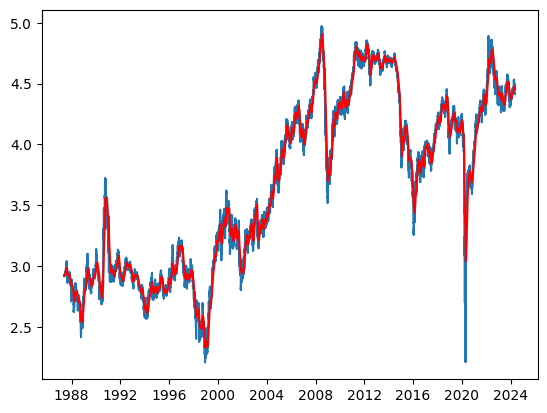

In [62]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

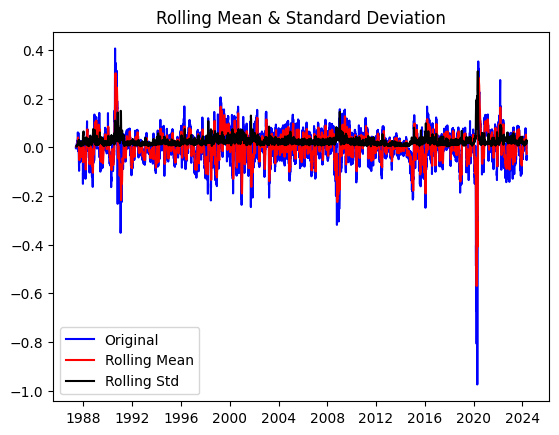

Results of Dickey Fuller Test:
Test Statistic                -1.420552e+01
p-value                        1.757642e-26
#Lags Used                     2.600000e+01
Number of Observations Used    1.114200e+04
Critical Value (1%)           -3.430937e+00
Critical Value (5%)           -2.861799e+00
Critical Value (10%)          -2.566908e+00
dtype: float64


In [63]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

**Teste 3 - Diferenciação**

Removendo a tendencia e tornando a série mais estacionária

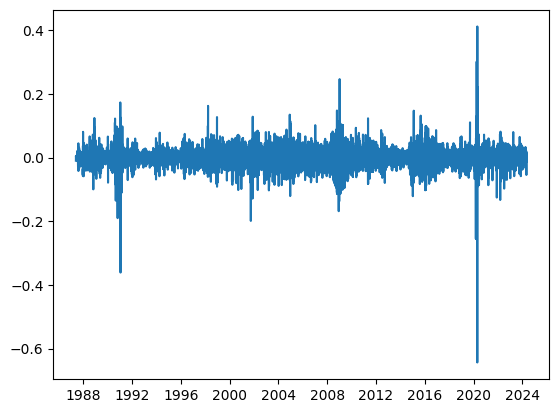

In [64]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
plt.plot(datasetLogDiffShifting)

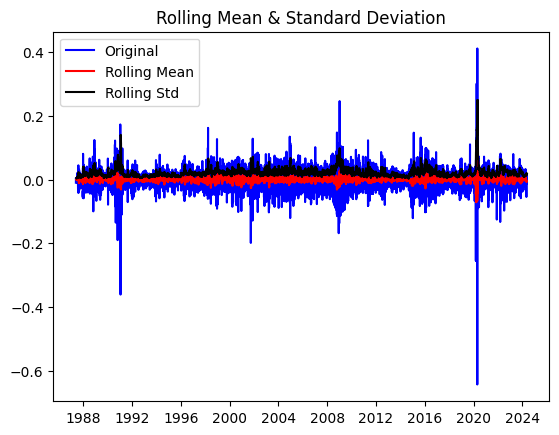

Results of Dickey Fuller Test:
Test Statistic                   -19.191431
p-value                            0.000000
#Lags Used                        25.000000
Number of Observations Used    11142.000000
Critical Value (1%)               -3.430937
Critical Value (5%)               -2.861799
Critical Value (10%)              -2.566908
dtype: float64


In [65]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

#### Aplicando os testes de correlação parcial para definição dos hiperparâmetros a serem utilizados no ARIMA

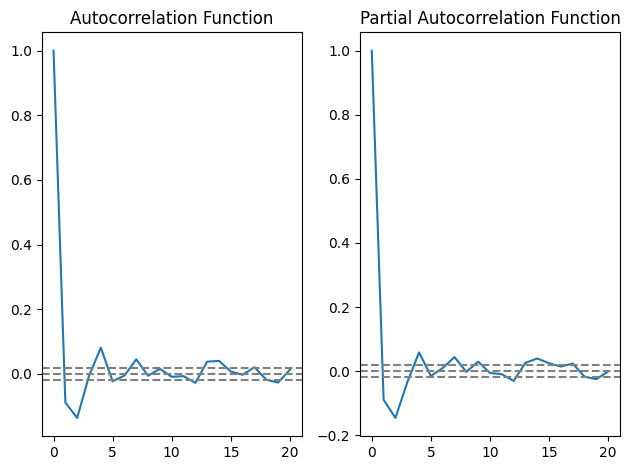

In [66]:
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

> Pelo gráfico ACF podemos verificar o valor em que a curva toca a linha y=0,0 em x=1 (Q=2)
>
> Pelo gráfico PACF podemos verificar o valor em que a curva toca a linha y=0,0 em x=1 (P=2)
>
> Estes valores serão utilizados como parâmtros do modelo ARIMA

#### Criando o modelo ARIMA com os parâmtros Q=2 e P=2

Plotting AR model


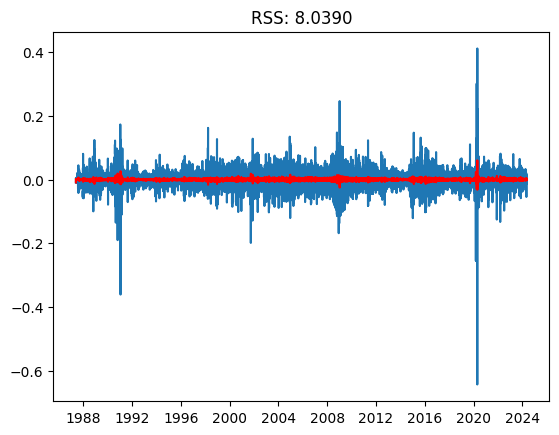

In [67]:
model = ARIMA(datasetLogDiffShifting, order=(2,1,2)) #(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Fechamento'])**2))
print('Plotting AR model')

**Validação com MAPE (Mean Absolute Percentage Error)**

In [68]:
# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Fechamento'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Fechamento'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 348.66%


>Este valor de MAPE indica que as previsões do modelo ARIMA para esta série temporal estão muito distantes dos valores reais